In [2]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
import keras
from scipy import spatial
from keras import layers
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from keras.preprocessing import image
tfkl = tfk.layers

In [3]:
data_img = pd.read_csv("/kaggle/input/fashion-product-images-dataset/fashion-dataset/images.csv")


In [4]:
data_sty = pd.read_csv("/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv", error_bad_lines=False)
data_img['id'] = data_img['filename'].apply(lambda x: x.replace(".jpg","")).astype(int)
data = data_sty.merge(data_img,on='id',how='left').reset_index(drop=True)
data['filename'] = data['filename'].apply(lambda x: os.path.join("../input/fashion-product-images-dataset/fashion-dataset/images/",x))

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [5]:
image_files = os.listdir("../input/fashion-product-images-dataset/fashion-dataset/images")
data['file_found'] = data['id'].apply(lambda x: f"{x}.jpg" in image_files)
data = data[data['file_found']].reset_index(drop=True)

In [35]:
data.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,../input/fashion-product-images-dataset/fashio...,http://assets.myntassets.com/v1/images/style/p...,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,../input/fashion-product-images-dataset/fashio...,http://assets.myntassets.com/v1/images/style/p...,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,../input/fashion-product-images-dataset/fashio...,http://assets.myntassets.com/v1/images/style/p...,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,../input/fashion-product-images-dataset/fashio...,http://assets.myntassets.com/v1/images/style/p...,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,../input/fashion-product-images-dataset/fashio...,http://assets.myntassets.com/v1/images/style/p...,True


In [7]:
def read_image(image_id):
    img = image.load_img(data['filename'][image_id])
    if img.shape != (2400,1800,3):
        img = image.load_img(data['filename'][image_id], target_size=(2400,1800,3))
        img = image.img_to_array(img)
    return img

In [8]:
def plot_image(image_id):
    img = image.load_img(data['filename'][image_id])
    plt.imshow(img)

### image embedding

In [9]:
from keras.applications.resnet50 import ResNet50

tfkl = tfk.layers

In [10]:
def build_model(in_shape):
    #build model for embedding
    resnet_base = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = in_shape)
    resnet_base.trainable = False
    
    model = tfk.Sequential()
    model.add(resnet_base)
    model.add(tfkl.GlobalMaxPooling2D()) #add layer embedding
    print(model.summary())
    return model

In [11]:
in_shape = [2400,1800,3]
model_resnet = build_model(tuple(in_shape))

94773248/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 75, 57, 2048)      23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________
None


we have to reshape the images, because not every image is in the same shape

In [16]:
def get_embedding(mod, image_id, in_shape):
    # Reshape and load image
    img = image.load_img(data['filename'][image_id], target_size=in_shape)
    img = image.img_to_array(img)
    return mod.predict(img.reshape(tuple([1]+in_shape))).reshape(1,-1)

In [ ]:
numRows = data.shape[0]
numCols = 2048 #Output diamensions of model
emb_matrix = pd.DataFrame(index=range(numRows),columns=range(numCols))

In [ ]:
%%time
# Compute every image's embedding in df, and attach it as a column
for i in range(0,len(data)):
    im = i
    emb = get_embedding(model,im,in_shape)
    emb_matrix.iloc[i,:]=emb

In [ ]:
emb_matrix.head(5)

In [ ]:
#store emb_matrix
emb_matrix.to_csv("emb_matrix.csv",index=False)

In [12]:
emb_matrix_resnet = pd.read_csv("/kaggle/input/resnet50-emb/emb_matrix.csv")
emb_store_resnet = pd.concat([emb_matrix_resnet, data[["filename","id"]]],axis=1,ignore_index=False)

## 

VGG16

In [13]:
from keras.applications.vgg16 import VGG16

tfkl_vgg = tfk.layers

In [14]:
def build_model_vgg16(in_shape,high_d=True):
    vgg_base =  VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape = in_shape)
    vgg_base.trainable = False
    
    model = tfk.Sequential()
    model.add(vgg_base)
    model.add(tfkl.GlobalMaxPooling2D()) #add layer embedding
    print(model.summary())
    return model

In [15]:
in_shape = [2400,1800,3]
model_vgg = build_model_vgg16(tuple(in_shape))

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 75, 56, 512)       14714688  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
numRows = data.shape[0]
numCols = 512 #Output diamensions of model
emb_matrix_vgg16 = pd.DataFrame(index=range(numRows),columns=range(numCols))

In [ ]:
%%time
# Compute every image's embedding in df, and attach it as a column
for i in range(0,len(data)):
    im = i
    emb = get_embedding(model,im,in_shape)
    emb_matrix_vgg16.iloc[i,:]=emb

In [ ]:
emb_matrix_vgg16.head(5)

In [ ]:
emb_matrix_vgg16.to_csv("emb_matrix_vgg.csv",index=False)

In [16]:
emb_matrix_vgg = pd.read_csv("/kaggle/input/vgg16emb/emb_matrix_vgg.csv")
emb_store_vgg = pd.concat([emb_matrix_vgg, data[["filename","id"]]],axis=1,ignore_index=False)

In [17]:
def get_embedding_input(model, image_id, in_shape, user_input):
    # Reshape and load image
    if user_input == True:
        img = image.load_img(image_id, target_size=in_shape)
    else:
        img = image.load_img(data['filename'][image_id], target_size=in_shape)
    img = image.img_to_array(img)
    if model=='resnet':
        return model_resnet.predict(img.reshape(tuple([1]+in_shape))).reshape(1,-1)
    elif model=='vgg':
        return model_vgg.predict(img.reshape(tuple([1]+in_shape))).reshape(1,-1)

In [21]:
indices = pd.Series(range(len(data)), index=data.index)

def get_cos_similarity(model,image_id,user_input):
    emb = get_embedding_input(model,image_id,in_shape,user_input) #(1, 2400, 1800, 3)
    emb = pd.DataFrame(emb)
    #print(emb)
    if model=='resnet':
        cos_similarity = cosine_similarity(emb, emb_matrix_resnet)
    elif model=='vgg':
        cos_similarity = cosine_similarity(emb, emb_matrix_vgg)
    return cos_similarity


In [19]:
def get_recommendations(df, similarity):
    """ Return the top 5 most similar products """
    sim_scores = list(enumerate(similarity[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:6]
    #print(sim_scores)
    indices = [i[0] for i in sim_scores]
    # Return the top 5 most similar products
    return indices

[(34569, 0.9999999999996149), (36172, 0.9710303064169409), (6095, 0.9585887924513937), (15711, 0.9553332694345227), (13591, 0.9541279494368049), (13362, 0.9539162656971077)]
Tshirts
Tshirts
Tshirts
Tshirts
Tshirts
Tshirts


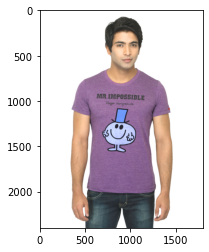

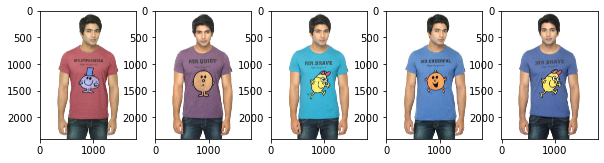

In [35]:
model = 'resnet'
id = 34569
user_input = False
similarity = get_cos_similarity(model ,id,user_input)
recommendation = get_recommendations(data, similarity)
print(data['articleType'][recommendation[0]])
plot_image(recommendation[0])
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 1
i = 1
for img in recommendation[1:]:
    print(data['articleType'][img])
    fig.add_subplot(rows, columns, i)
    plot_image(img)
    i+=1
plt.show()


Accuracy:

Resnet

In [43]:
model = 'resnet'
correct = 0
for id in range(1,500):
    similarity = get_cos_similarity(model ,id)
    recommendation = get_recommendations(data, similarity)
    input_type = data['articleType'][id]
    for img in recommendation[1:]:
        if input_type == data['articleType'][img]:
            correct +=1
print(correct)
accuracy = correct/2500*100
print("Accuracy for resnet=",accuracy)

1978
Accuracy for resnet= 79.12


VGG

In [44]:
model = 'vgg'
correct = 0
for id in range(1,500):
    similarity = get_cos_similarity(model ,id)
    recommendation = get_recommendations(data, similarity)
    input_type = data['articleType'][id]
    for img in recommendation[1:]:
        if input_type == data['articleType'][img]:
            correct +=1
print(correct)
accuracy_vgg = correct/2500*100
print("Accuracy for vgg=",accuracy_vgg)

1830
Accuracy for vgg= 73.2


Dresses
Dresses
Tunics
Dresses
Tops


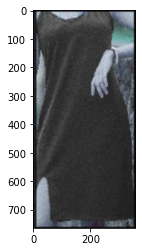

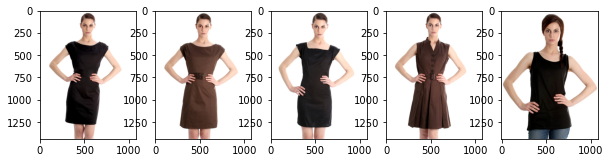

In [46]:
model = 'resnet'
id = "/kaggle/input/test-image-obj-detection/WhatsApp Image 2023-02-15 at 2.44.52 PM (1).jpeg"
#id = 1142
user_input = False
similarity = get_cos_similarity(model ,id,user_input)
recommendation = get_recommendations(data, similarity)
#print(data['articleType'][recommendation[0]])
img = cv2.imread(id1)
frame_rgb = np.flip(img,axis=2)
plt.imshow(frame_rgb)
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 1
i = 1
for img in recommendation[0:5]:
    print(data['articleType'][img])
    fig.add_subplot(rows, columns, i)
    plot_image(img)
    i+=1
plt.show()